TODO list:

- build 3 corner reflectors
- make 3 long wires for servos
- mount 3 servos + reflectors
- command all 3 simulaneously

In [1]:
from utils import *
%matplotlib inline

In [2]:
from servos import Servos
    
if 'servos' in locals():
    servos.read_stop = True
    time.sleep(0.1)
servos = Servos(3, '/dev/ttyACM0')

In [10]:
#####################
# Test ServosSerial #
#####################

speed = np.pi/4
ith = 2

t0 = time.time()
a0, _ = servos.set_angle(ith, servos.min_angle, speed)
a1, _ = servos.set_angle(ith, servos.max_angle, speed)
a2, _ = servos.set_angle(ith, 0, speed)
t1 = time.time()

print('[a0, a1]: [{0}, {1}]'.format(a0, a1))
print('Elapsed: {0}'.format(t1 - t0))

[a0, a1]: [-0.769, 0.769]
Elapsed: 4.02107095718


In [3]:
from sdrs import SDRs

num_sdrs = 3
fc = 910e6

dev_cnt = librtlsdr.rtlsdr_get_device_count()
print('Devices found: {0}'.format(dev_cnt))
rtlsdr_devs = [i if i < dev_cnt else None for i in xrange(num_sdrs)]
sdrs = SDRs(rtlsdr_devs, fc)

Devices found: 1


In [3]:
#############
# Test SDRs #
#############
ith = 0

print('Start reading')
sdrs.start_read(ith)
print('Sleeping...')
time.sleep(1)
print('Stop reading')
x = np.array([])
start = time.time()
x = sdrs.stop_read(ith)
print('len(x): {0}'.format(len(x)))
print('time to stop: {0}'.format(time.time() - start))

Start reading
Sleeping...
Stop reading
len(x): 56
time to stop: 0.000327110290527


In [4]:
from servos_sdrs import ServosSDRs

servos_sdrs = ServosSDRs(servos, sdrs)

In [26]:
###################
# Test ServosSDRs #
###################

sdrs.set_gains(1)

"""
ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

try:
    p.terminate()
except:
    pass
p = pyaudio.PyAudio()
Qout = play_pure_tone_continuously(p, ham, 2000., mag=0.5)
"""

antennas = [0]
for ith in antennas:
    servos_sdrs.start(ith, speed=np.pi/5.)

print('Press enter to stop')
raw_input()

for ith in antennas:
    servos_sdrs.stop(ith)

"""
ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()
"""

angles_and_maxpowers = list()
for ith in antennas:
    print('Computing for {0}th'.format(ith))
    a_mp_list = list()
    a_mp = servos_sdrs.get_angles_and_maxpowers(ith)
    while a_mp is not None:
        print('Reading a,mp')
        a_mp_list.append(a_mp)
        a_mp = servos_sdrs.get_angles_and_maxpowers(ith)
    print('{0}th rotations: {1}'.format(ith, len(a_mp_list)))
    angles_and_maxpowers.append(a_mp_list)

ServosSdrs: run 0th
Press enter to stop

ServosSdrs: stopping 0th
Computing for 0th
Reading a,mp
Reading a,mp
Reading a,mp
0th rotations: 3


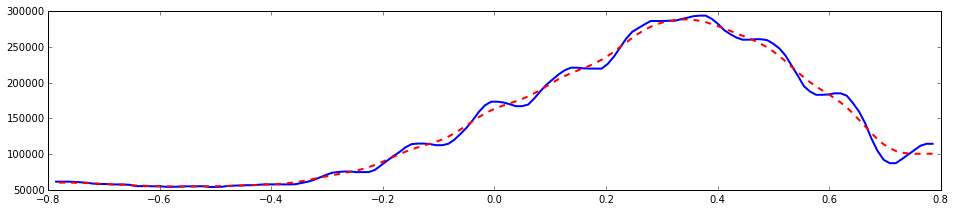

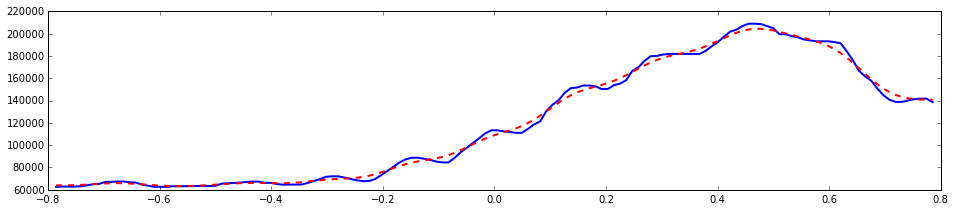

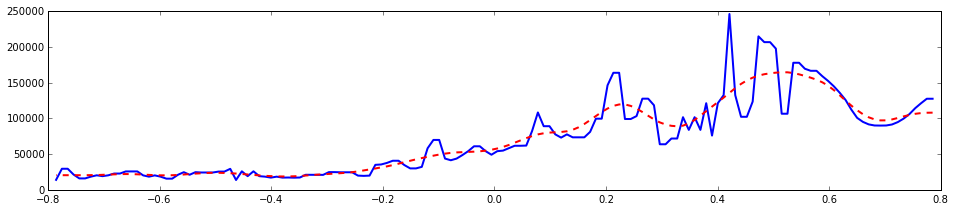

In [32]:
for a_mp_list in angles_and_maxpowers:
    for angles, mp in a_mp_list:
        #mp_smooth = smoothMaxPower(mp, 100)
        #angles = np.linspace(angles[0], angles[-1], len(mp))
        angles = angles[::-1]

        width, height = plt.figaspect(0.2)
        f, ax = plt.subplots(1,1, figsize=(width,height))
        
        import scipy.signal as signal
        mp_med = signal.medfilt(mp, 3)
        ax.plot(angles, mp_med, 'b-', linewidth=2.0)
        ax.plot(angles, smoothMaxPower(mp_med, 20), 'r--', linewidth=2.0)
        
        #axes[0].plot(angles, mp)
        #axes[0].plot(angles, mp_smooth, 'r--', linewidth=2.0)
        #axes[1].plot(angles, 1 - mp/mp.sum())
        #axes[1].plot(angles, mp_smooth/mp_smooth.sum(), 'r--', linewidth=2.0)
        #plt.ylim((mp.mean()-3*mp.std(), mp.mean()+3*mp.std()))

In [3]:
#####################################
# Test shielding makes a difference #
#####################################

duration = 6.0
time.sleep(0.2)
sdrs.set_gains(.01)
sdrs.start_read(0)
time.sleep(duration-0.2)
data = sdrs.stop_read(0)

print('len(data): {0}'.format(len(data)))

len(data): 1376256


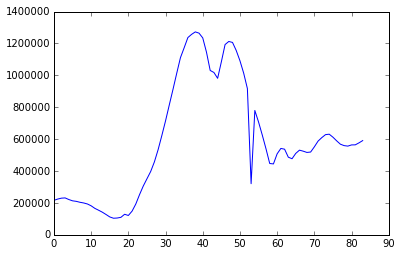

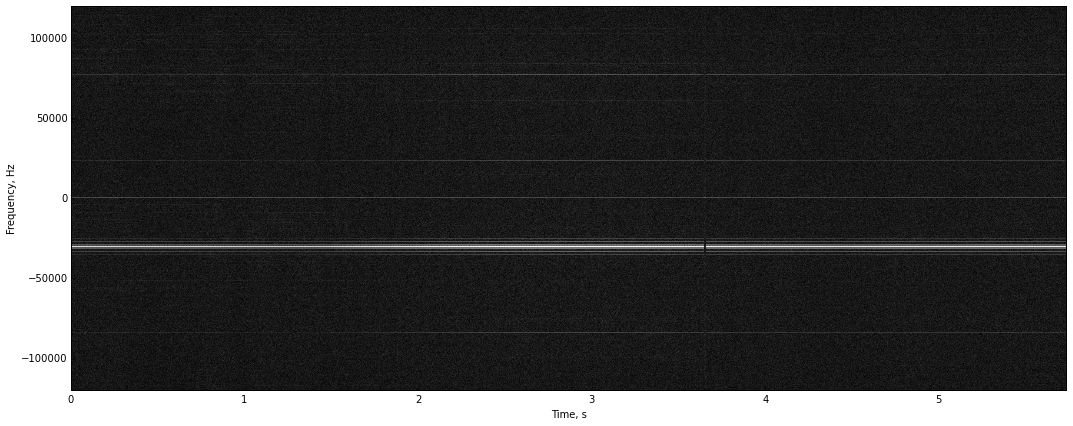

In [4]:
#f = plt.figure()
#plt.plot(np.real(data))

f = plt.figure()
mp = maxPower(data, 16*1024)
plt.plot(mp)

_ = myspectrogram_hann_ovlp(data, 1024, sdrs.fs, 0)